In [6]:
import sys
from typing import List

import matplotlib
import requests
from pydantic import BaseModel


class OpenRankEntryItem(BaseModel):
    name: str


class OpenRankEntry(BaseModel):
    item: OpenRankEntryItem
    rank: int
    value: float
    rankDelta: int
    valueDelta: float


class OpenRank(BaseModel):
    type: str
    time: int
    data: List[OpenRankEntry]


year_range = range(2015, 2024)
region_list = ["chinese", "global"]

chinese_list: List[OpenRank] = []
global_list: List[OpenRank] = []

for year in year_range:
    for region in region_list:
        url = f"http://xlab-open-source.oss-cn-beijing.aliyuncs.com/open_leaderboard/open_rank/company/{region}/{year}.json"
        try:
            response = requests.get(
                url,
                headers={
                    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36 Edg/120.0.0.0"
                },
            )
            response.raise_for_status()

        except Exception as e:
            print(f"Error fetching data for year {year}: {e}")
            sys.exit()
        if response.status_code == 200:
            raw_dict = response.json()
            if region == "chinese":
                chinese_list.append(OpenRank.model_validate(raw_dict))
            else:
                global_list.append(OpenRank.model_validate(raw_dict))
    

In [7]:
# 展示数据是否正确
chinese_list[-1].data[0]
global_list[-1].data[0]

OpenRankEntry(item=OpenRankEntryItem(name='Microsoft'), rank=1, value=215043.71, rankDelta=0, valueDelta=8453.06)

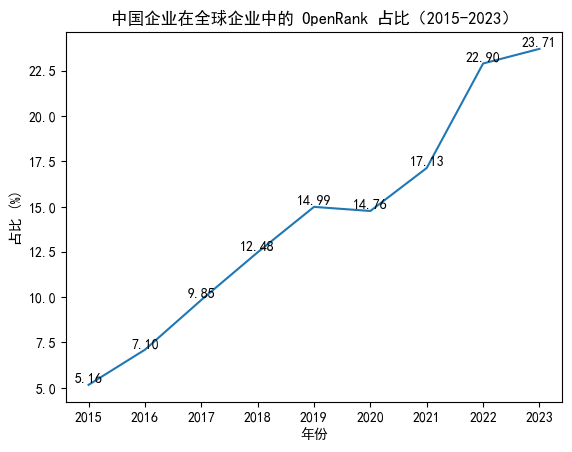

In [10]:
import matplotlib.pyplot as plt
matplotlib.rcParams['font.family'] = 'SimHei'
matplotlib.rcParams['font.size'] = 10
# 数据准备
years = list(year_range)
idx_list = list(range(len(chinese_list)))
china_company_percentage = [0] * len(idx_list)
for idx in idx_list:
    chinese_total = sum(entry.value for entry in chinese_list[idx].data)
    global_total = sum(entry.value for entry in global_list[idx].data)
    china_company_percentage[idx] = chinese_total/global_total*100
# 创建折线图
plt.plot(years, china_company_percentage)

# 在每个点上添加数值标签
for x, y in zip(years, china_company_percentage):
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom')
    
# 添加标题和标签
plt.title('中国企业在全球企业中的 OpenRank 占比（2015-2023）')
plt.xlabel('年份')
plt.ylabel('占比 (%)')

# 显示图表
plt.show()